# Analysis of Pizza Restaurant 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CS

file_path = '../input/luigis-pizza-restaurant/data.xlsx'
sheets = pd.read_excel(file_path, sheet_name = None)

print('Sheets in the excel file: ', sheets.keys())

Sheets in the excel file:  dict_keys(['data_dictionary', 'pizza_types', 'pizzas', 'order_details', 'orders'])


In [2]:
# inspect each sheet
data_dictionary = sheets['data_dictionary']
pizza_types = sheets['pizza_types']
pizzas = sheets['pizzas']
order_details = sheets['order_details']
orders = sheets['orders']

# summarise each sheet
summary = {
    "data_dictionary": data_dictionary.head(),
    "pizza_types": pizza_types.head(),
    "pizzas": pizzas.head(),
    "order_details": order_details.head(),
    "orders": orders.head(),
}

print('SUMMARY: ', summary)

SUMMARY:  {'data_dictionary':            Table             Field  \
0         orders          order_id   
1         orders              date   
2         orders              time   
3  order_details  order_details_id   
4  order_details          order_id   

                                         Description  
0  Unique identifier for each order placed by a t...  
1  Date the order was placed (entered into the sy...  
2  Time the order was placed (entered into the sy...  
3  Unique identifier for each pizza placed within...  
4  Foreign key that ties the details in each orde...  , 'pizza_types':   pizza_type_id                          name category  \
0       bbq_ckn    The Barbecue Chicken Pizza  Chicken   
1      cali_ckn  The California Chicken Pizza  Chicken   
2   ckn_alfredo     The Chicken Alfredo Pizza  Chicken   
3     ckn_pesto       The Chicken Pesto Pizza  Chicken   
4    southw_ckn   The Southwest Chicken Pizza  Chicken   

                                         ingre

* Given the structure of the .xlsx file, the entity-relationship model can be drawn considering these entities and relationships: pizzas, pizza_types, orders, order_details:

| **orders**         | **order_details**   | **pizzas**         | **pizza_types**     |
|--------------------|---------------------|--------------------|---------------------|
| order_id           | order_detail_id     | pizza_id           | pizza_type_id       |
| date               | order_id            | pizza_type_id      | name                |
| time               | pizza_id            | size               | category            |
|                    | quantity            | price              | ingredients         |
|                    |                     |                    |                     |
| Relationship       | One-to-many (1:N)   | One-to-many (1:N)  | Many-to-one (N:1)  |

## Summaries for each table

In [3]:
orders_sum = {
    'total_orders': orders['order_id'].nunique(),
    'date_range_for_orders': (orders['date'].min(), orders['date'].max())
}

order_details_sum = {
    'total_items_sold': order_details['quantity'].sum(),
    'most_popular_pizza': order_details.groupby('pizza_id')['quantity'].sum().idxmax()
}

pizza_types_sum = {
    'number_of_pizza_types': pizza_types['pizza_type_id'].nunique(),
    'pizza_categories': pizza_types['category'].unique()
}

pizzas_sum = {
    'price_range': (pizzas['price'].min(), pizzas['price'].max())
}

print('Summaries for each table: ')
{
    "orders_sum": orders_sum,
    "order_details_sum": order_details_sum,
    "pizza_types_sum": pizza_types_sum,
    "pizzas_sum": pizzas_sum
}


Summaries for each table: 


{'orders_sum': {'total_orders': 21350,
  'date_range_for_orders': (Timestamp('2015-01-01 00:00:00'),
   Timestamp('2015-12-31 00:00:00'))},
 'order_details_sum': {'total_items_sold': 49574,
  'most_popular_pizza': 'big_meat_s'},
 'pizza_types_sum': {'number_of_pizza_types': 32,
  'pizza_categories': array(['Chicken', 'Classic', 'Supreme', 'Veggie'], dtype=object)},
 'pizzas_sum': {'price_range': (9.75, 35.95)}}

## Parse ingredients from 'pizza_types' and find out which one is most used

In [4]:
ingr = pizza_types['ingredients'].str.split(', ').sum()
ingr_count = {}

for ingredient in ingr:
    if ingredient in ingr_count:
        ingr_count[ingredient] += 1
    else:
        ingr_count[ingredient] = 1

most_used_ingr = max(ingr_count.items(), key = lambda x: x[1])

most_used_ingr = [most_used_ingr]

most_used_ingr

[('Garlic', 17)]

* Garlic is the most used ingredient, present in 17 pizza types.

## Number of cheese types 

In [5]:
cheese_types = [ingr for ingr in ingr_count if 'cheese' in ingr.lower()]

print('Number of cheese types: ', len(cheese_types), '\n')
print(cheese_types)

Number of cheese types:  16 

['Fontina Cheese', 'Gouda Cheese', 'Asiago Cheese', 'Mozzarella Cheese', 'Tomatoes; Goat Cheese', 'Feta Cheese', 'Brie Carre Cheese', 'Mozarella Cheese', 'Goat Cheese', 'Provolone Cheese', 'Smoked Gouda Cheese', 'Romano Cheese', 'Blue Cheese', 'Ricotta Cheese', 'Gorgonzola Piccante Cheese', 'Parmigiano Reggiano Cheese']


## Pizza of each type and size sold 

In [6]:
# merge order_details and pizzas df on pizza_id (common feature)
combined = order_details.merge(pizzas, on = 'pizza_id')
#print(combined)

# group by pizza_type_id and size, then sum the quantity to find the total quantity of pizzas sold for each pizza type and size combination
pizza_sold = combined.groupby(['pizza_type_id', 'size'])['quantity'].sum()

pizza_sold = pizza_sold.reset_index()

pizza_sold

,pizza_type_id,size,quantity
0,bbq_ckn,L,992
1,bbq_ckn,M,956
2,bbq_ckn,S,484
3,big_meat,S,1914
4,brie_carre,S,490
...,...,...,...
86,the_greek,XL,552
87,the_greek,XXL,28
88,veggie_veg,L,427
89,veggie_veg,M,635


## Top 5 most ordered pizza

In [7]:
# merge order_details and pizzas df on pizza_id
combined = order_details.merge(pizzas, on='pizza_id')

# find the total quantity of pizzas sold for each combination of pizza type and size:
# group by pizza_type_id and size
# add up all the individual quantities of pizzas sold
top_5 = combined.groupby(['pizza_type_id', 'size'])['quantity'].sum().nlargest(5).reset_index()

# merge top_5 with pizza_types df to get pizza names
top_5_names = top_5.merge(pizza_types, on = 'pizza_type_id')

top_5_names

,pizza_type_id,size,quantity,name,category,ingredients
0,big_meat,S,1914,The Big Meat Pizza,Classic,"Bacon, pepperoni, Italian Sausage, Chorizo Sau..."
1,thai_ckn,L,1410,The Thai Chicken Pizza,Chicken,"Chicken, Pineapple, Tomatoes, Red Peppers, Tha..."
2,five_cheese,L,1409,The Five Cheese Pizza,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go..."
3,four_cheese,L,1316,The Four Cheese Pizza,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo..."
4,classic_dlx,M,1181,The Classic Deluxe Pizza,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,..."


## Pizza never sold in 2015

In [8]:
all_pizzas = set(pizzas['pizza_id']) # set containing all unique pizza id's available in the pizzas df
sold_pizzas = set(order_details['pizza_id'])
never_sold_p = all_pizzas - sold_pizzas

never_sold_p

{'big_meat_l', 'big_meat_m', 'five_cheese_m', 'five_cheese_s', 'four_cheese_s'}

## Summary statistics for pizza prices for each size category

In [9]:
# calculate revenue: merge order_details with pizzas -> to get price info
order_details_with_price = order_details.merge(pizzas[['pizza_id', 'price']], on = 'pizza_id')

order_details_with_price['revenue'] =  order_details_with_price['quantity'] * order_details_with_price['price']

#print(order_details_with_price['revenue'], '\n'*2)

# calculate price statistics for different pizza sizes:
# group the pizza of same size together, 
# apply aggregation function to the price column within each size group
price_stats = pizzas.groupby('size')['price'].agg(['mean', 'min', 'max']).reset_index()

price_stats

,size,mean,min,max
0,L,20.022581,15.25,21.00
1,M,15.991935,12.50,16.75
2,S,12.512500,9.75,23.65
3,XL,25.500000,25.50,25.50
4,XXL,35.950000,35.95,35.95


## Distribution of prices

<function matplotlib.pyplot.show(close=None, block=None)>

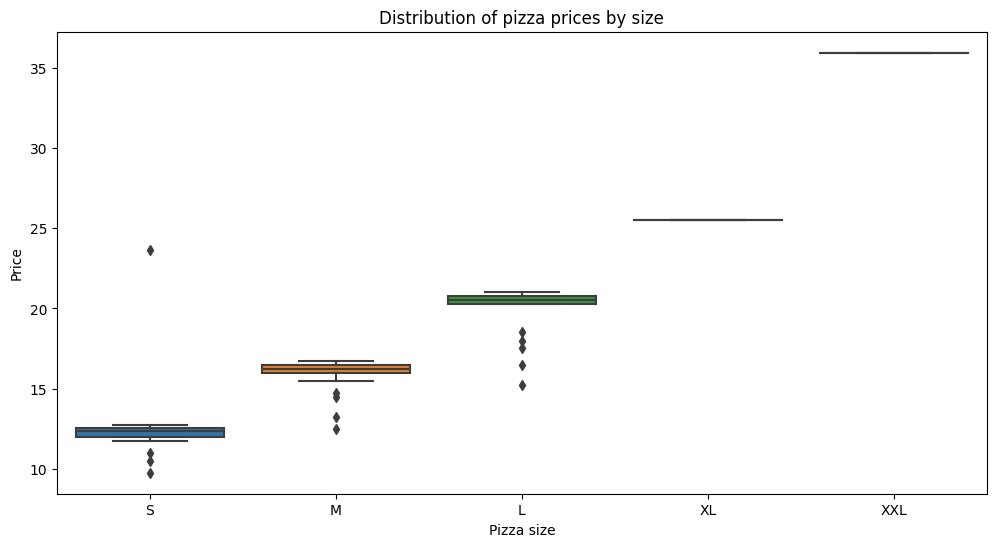

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (12, 6))
sns.boxplot(x = 'size', y = 'price', data = pizzas, order = ['S', 'M', 'L', 'XL', 'XXL'])
plt.title('Distribution of pizza prices by size')
plt.xlabel('Pizza size')
plt.ylabel('Price')
plt.show

* Pizza of sizes S, M and L have prices in a specific range, while those of size XL and XXL have the same price regarding their type. Also, as the size of the pizza increases, so does the prices.

## Total revenue generated in 2015

In [11]:
total_revenue = order_details_with_price['revenue'].sum()

total_revenue

817860.05

## Total revenue generated each month of 2015

In [12]:
orders_revenue = orders.merge(order_details_with_price, on = 'order_id')
orders_revenue['date'] = pd.to_datetime(orders_revenue['date'])
orders_revenue['month'] = orders_revenue['date'].dt.month

monthly_revenue = orders_revenue.groupby('month')['revenue'].sum()

monthly_revenue

month
1     69793.30
2     65159.60
3     70397.10
4     68736.80
5     71402.75
6     68230.20
7     72557.90
8     68278.25
9     64180.05
10    64027.60
11    70395.35
12    64701.15
Name: revenue, dtype: float64

## Order frequency visualization over time

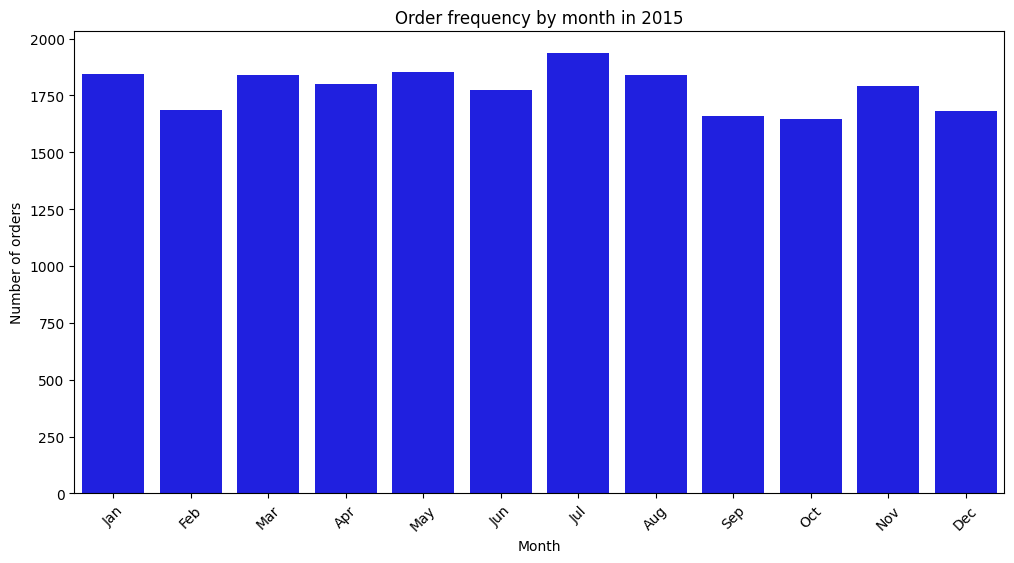

In [13]:
monthly_orders = orders_revenue.groupby('month')['order_id'].nunique()

plt.figure(figsize = (12, 6))
sns.barplot(x = monthly_orders.index, y = monthly_orders.values, color = 'blue')
plt.title('Order frequency by month in 2015')
plt.xlabel('Month')
plt.ylabel('Number of orders')
plt.xticks(ticks = range(12), labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation = 45)
plt.show()

* This visualization aligns with the revenue trends, which means that the more orders are places, inherently, the revenue increases. 

## Number of orders handled in a day on average

In [14]:
orders['date'] = pd.to_datetime(orders['date']) # convert the date to datetime format
daily_orders = orders['date'].value_counts()
average_daily_orders = daily_orders.mean()

average_daily_orders

59.63687150837989

In [15]:
results_table = {
    "most_used_ingredient": most_used_ingr,
    "number_of_cheese_types": cheese_types,
    "cheese_types": cheese_types,
    "pizza_sales_by_type_and_size": pizza_sold.head(), 
    "top_5_pizzas": top_5,
    "never_sold_pizzas": list(never_sold_p),
    "price_stats_by_size": price_stats,
    "total_revenue_2015": total_revenue,
    "average_orders_per_day": average_daily_orders
}

for key, value in results_table.items():
    print(f"{key}: {value}\n")


most_used_ingredient: [('Garlic', 17)]

number_of_cheese_types: ['Fontina Cheese', 'Gouda Cheese', 'Asiago Cheese', 'Mozzarella Cheese', 'Tomatoes; Goat Cheese', 'Feta Cheese', 'Brie Carre Cheese', 'Mozarella Cheese', 'Goat Cheese', 'Provolone Cheese', 'Smoked Gouda Cheese', 'Romano Cheese', 'Blue Cheese', 'Ricotta Cheese', 'Gorgonzola Piccante Cheese', 'Parmigiano Reggiano Cheese']

cheese_types: ['Fontina Cheese', 'Gouda Cheese', 'Asiago Cheese', 'Mozzarella Cheese', 'Tomatoes; Goat Cheese', 'Feta Cheese', 'Brie Carre Cheese', 'Mozarella Cheese', 'Goat Cheese', 'Provolone Cheese', 'Smoked Gouda Cheese', 'Romano Cheese', 'Blue Cheese', 'Ricotta Cheese', 'Gorgonzola Piccante Cheese', 'Parmigiano Reggiano Cheese']

pizza_sales_by_type_and_size:   pizza_type_id size  quantity
0       bbq_ckn    L       992
1       bbq_ckn    M       956
2       bbq_ckn    S       484
3      big_meat    S      1914
4    brie_carre    S       490

top_5_pizzas:   pizza_type_id size  quantity
0      big_mea

## Is there a day of the week that is more crowded?

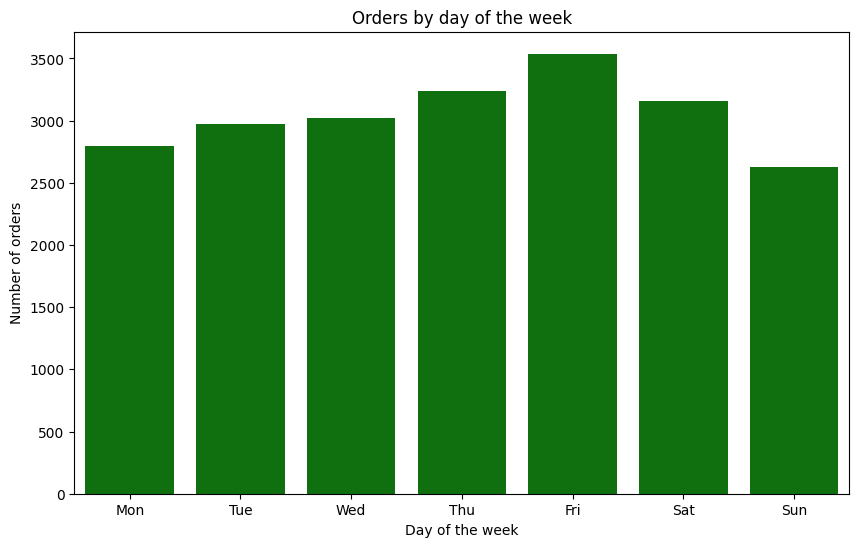

In [16]:
orders_revenue['week_day'] = orders_revenue['date'].dt.dayofweek
week_day_orders = orders_revenue.groupby('week_day')['order_id'].nunique()

#print(week_day_orders)

plt.figure(figsize = (10, 6))
sns.barplot(x = week_day_orders.index, y = week_day_orders.values, color = 'green')
plt.title('Orders by day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Number of orders')
plt.xticks(ticks = range(7), labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

* Friday seems to be the busiest day of the week.

## Is there a day of the week that generated more revenue?

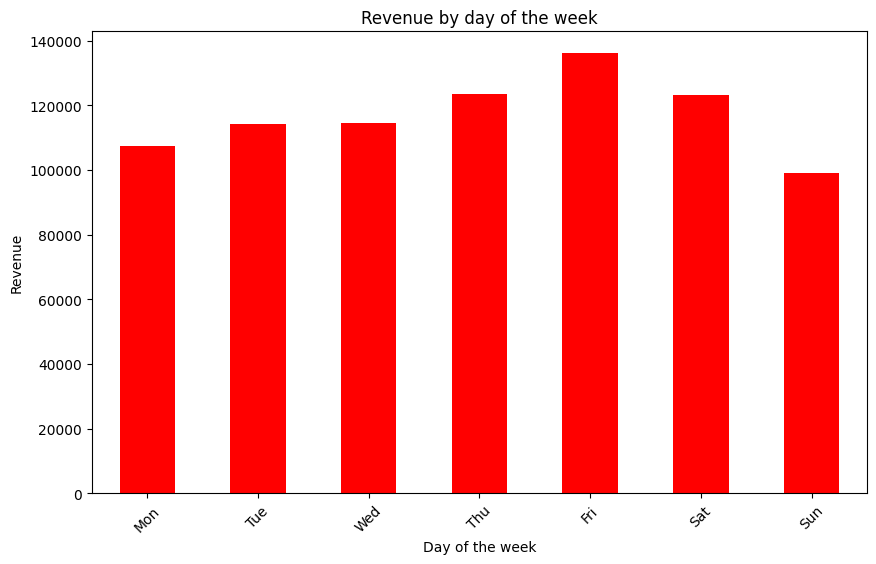

In [17]:
week_day_revenue = orders_revenue.groupby('week_day')['revenue'].sum()

plt.figure(figsize = (10, 6))
week_day_revenue.plot(kind = 'bar', color = 'red')
plt.title('Revenue by day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Revenue')
plt.xticks(ticks = range(7), labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)
plt.show()

* As it's the busiest day of the week, Fridays also generate more revenue.

## Are there periods of time where the restaurant sold no pizza? Why is that?

In [18]:
# identify days with no orders

date_range = pd.date_range(start = '2015-01-01', end = '2015-12-31')

# daily orders count
daily_orders = orders.groupby('date')['order_id'].nunique()

# days with no orders
# return a new set containing elements that are present in the date_range set, but not in the daily_orders.index set
no_orders_days = date_range.difference(daily_orders.index)

no_orders_days_result = pd.DataFrame({'Days with no orders': no_orders_days})

no_orders_days_result

,Days with no orders
0,2015-09-24
1,2015-09-25
2,2015-10-05
3,2015-10-12
4,2015-10-19
5,2015-10-26
6,2015-12-25


* Probably sales were absent on these days because the restaurant was close due to bank holidays (as Christmans Day can be observed).